<a href="https://colab.research.google.com/github/IshaKanani/-data_mgmt_rsch_life_cycle/blob/master/Week_9_Cleaning_data_data_preprocessing_and_organizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Learning objectives

* Introduce draw.io for flowcharts
* Planning out a pipeline to perform the process
* Defining functions to perform subtasks of a pipeline
* Calling these functions to implement the pipeline
* Utilizing different packages learned till now all together to serve a purpose

![week9 pipeline](https://drive.google.com/open?id=1G0TZCuvnzCxLKj3QgJvIA2QtpfJLjEln)


#Flowchart

* To explain the pipeline process easily
* Created using [draw.io](https://www.draw.io/)
* Alternate option: [Lucidchart](https://www.lucidchart.com/)

Flowchart available at: https://drive.google.com/open?id=1G0TZCuvnzCxLKj3QgJvIA2QtpfJLjEln

Upload this image under the file section as "Week9_pipeline.png", and the code chunk below should run fine.

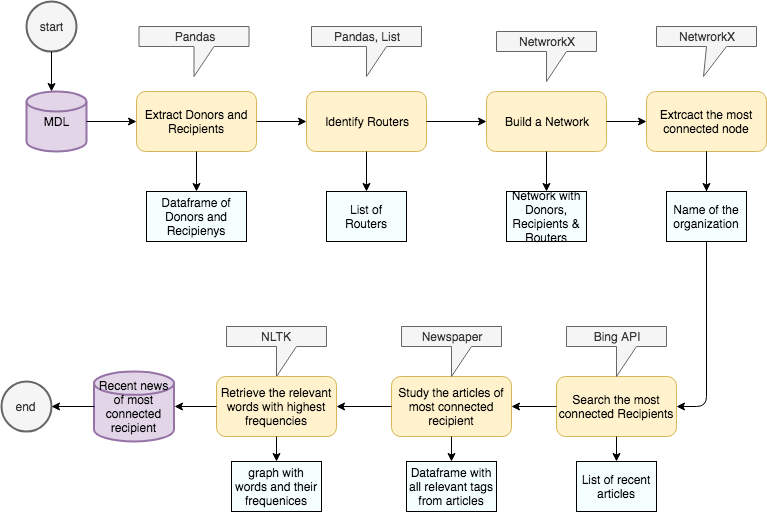

In [0]:
from IPython.display import Image
Image('week9_pipeline.png')

#The process

* The whole process from start to end is broken down into **small functions** to **reduce the complexity.**

* In the next few cells, we will **define** the function, and then **call** it to create the pipeline.

* Main points to understand what a function is:

  I. Creating a function
  
  II. Taking parameters
  
  III. Returning value(s)
  
  IV. Calling a function.
  
  Learn more about a function [here](https://www.w3schools.com/python/python_functions.asp)

## 1.Getting Donors, Recipients and Routers

* Defining a function that would take the dataset as an input, and return Donors, Recipients and Routers
* Function name: **get_nodes()**

## 2.Building a Network

* Takes all three types of nodes as an input and return a network.
* Function name: **build_nw()**

In [0]:
import pandas as pd
import networkx as nx

def get_nodes(df_main):
  data_edges = df_main[["Donor Name", "Recipient"]]

  #print(data_edges.head(10))

  routers = []
  #routers.append(val for val in data_edges["Donor Name"].values.tolist() if val in data_edges["Recipient"].values.tolist())
  #print(routers)

  for val in data_edges["Donor Name"].drop_duplicates().values:
    if val in data_edges["Recipient"].values:
      routers.append(val)
      
  return data_edges, routers


def build_nw(data_edges, routers):
  G = nx.Graph()
  G.add_nodes_from(data_edges["Donor Name"], node_type="donor")
  G.add_nodes_from(data_edges["Recipient"], node_type="recipient")
  G.add_edges_from(data_edges.values)

  for val in routers:
    G.nodes[val]['node_type'] = "router"
    
  return G
  
  

## 3.Getting n most connected routers

* Takes the network, list of routers, and the number n as input paramers.
* Returns the top n most connected router names and number of connections as a pandas dataframe.
* Function name: **get_top_routers()**

In [0]:
def get_top_routers(nw, list_routers, n):

  degrees = []
  for val in list_routers:
    degrees.append(nw.degree(val))

  nodes_degrees = pd.DataFrame()
  nodes_degrees["org"] = nodes
  nodes_degrees["connections"] = degrees
  
  top_routers = nodes_degrees.sort_values("connections", ascending=False).head(n)
  return top_routers

## 4.Getting n urls for most popular router

* Takes the name of the router and number of urls wanted
* Gives the list of URLs
* Function name: **get_url_list()**

My subscription key has been disabled as all free trials are used. Need to find a new one.
Students who have their own subscription key can volunteer to offer their key for the lab conduction.

In [0]:
import json
import requests

def get_url_list(org, total_urls):
  headers = {
      # Request headers
      # Add any of the two keys from microsoft account here
      'Ocp-Apim-Subscription-Key': '56de6ee45d3e474b8a664174fcabdf81',
  }

  params = ({
      # Request parameters

      #q: Query or key word
      'q': org,

      #count: The number of articles to be retrieved
      'count': total_urls,

      #offset: The first number of articles to skip before retrieving the list
      'offset': '0',

      #mkt: The region/ country market to focus while retrieving articles
      #market codes: https://docs.microsoft.com/en-us/azure/cognitive-services/bing-web-search/language-support
      'mkt': 'en-us',

      'since': 2012,

      'sortyBy': 'date',

      #safesearch: A filter used to filter results for adult content.
      'safesearch': 'Off', #'Strict', 'Off', 'Moderate',
  })


  #Request a response by providing url, subscription key and cpnstraints
  response = requests.get("https://api.cognitive.microsoft.com//bing/v7.0/news/search?%s?", headers=headers, params=params)

  #Check for error
  response.raise_for_status()
  
  #Get the response in JSON format
  search_results = response.json()
  
  #Empty list
  url_list=[]

  #Retrieving urls from search_results['value']
  for value in search_results['value']:
    url_list.append(value['url'])
    
  return url_list

## 5.Get details of URLs

* Function takes the list of URLs and return the dataframe with the URL and the article text.
* Function name: **get_details()**

In [0]:
!pip install newspaper3k

    100% |████████████████████████████████| 215kB 26.3MB/s 
    100% |████████████████████████████████| 194kB 9.4MB/s 
    100% |████████████████████████████████| 7.4MB 1.1MB/s 
    100% |████████████████████████████████| 51kB 16.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Stored in directory: /root/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
Successfully built feedfinder2 feedparser jieba3k tinysegmenter


In [0]:
from newspaper import Article

def get_details(url_list):
  

  details_np = pd.DataFrame(columns=["url", "text"])

  for link in url_list:

    #Giving article link to newspaper
    billgates = Article(link)

    #Dowloading the article
    billgates.download()

    #Parsing the article
    billgates.parse()

    details=[link, billgates.text]

    details_np.loc[len(details_np)] = details
    
  return details_np

## 6.Generating list of words

* Function takes the dataframe as an input, and perform text processing on "text" to generate a list of words.
* Function name: **freq_dist()**

## 7.Plotting the most frequent words in the text field

* Function takes the list of words as an input and return the plot of most frequent words.
* Function name: **plot_words()**

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem.porter import *

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stemmer=PorterStemmer()
stop_words=stopwords.words('english')

def freq_dist(df):
  recipient_token_list=[]
  for entry in df["text"]:
      if str(entry)!='nan':
          recipient_token_list+=[stemmer.stem(s) for s in word_tokenize(entry) if s.lower() not in stop_words and s.isalpha()]

  return recipient_token_list

def plot_words(words):
  fd=nltk.FreqDist(words)
  return fd.plot(10, cumulative=False, figure=plt.figure())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Pipeline

The code chunks below will use all the previously defined functions to build a single pipeline

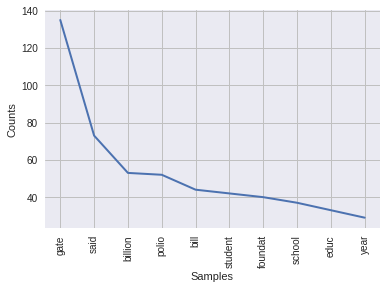

In [0]:
#1 Getting node names

df_mdl = pd.read_csv("https://mdphil.webtest.iu.edu/doc/donations.csv", encoding='latin-1')
dn_rc, routers = get_nodes(df_mdl)

#2 building network
network = build_nw(dn_rc, routers)

#3 finding top n routers
top_routers = get_top_routers(network, routers, 5)

#4 Getting the list of URLs
url_list = get_url_list(top_routers['org'].values[0], 20)

#5 Getting the text
details = get_details(url_list)

#6. Generating list of words
words = freq_dist(details)

#7. Plotting and getting a graph
plot_words(words)

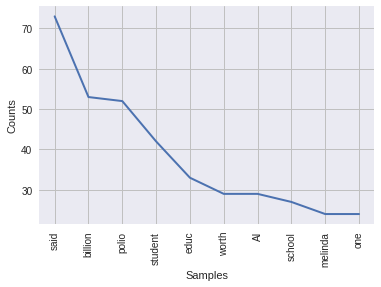

In [0]:
#Adding stop_words and repeating step 6 and 7

stop_words.extend(['gates', 'bill', 'foundation', 'school', 'year'])

#6. Generating list of words
words = freq_dist(details)

#7. Plotting and getting a graph
plot_words(words)